**CNN-LSTM model for Human Activity Recognition**


Experiements on [Pamap2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) dataset using different combinations of (with/without) x (channel, temporal and/or spatial attention). 

Baseline CNN-LSTM architecture used is proposed in [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition](https://www.mdpi.com/1424-8220/16/1/115/htm).  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install -q tensorflow-addons
!pip install keras
!pip install pyts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# https://github.com/Debarshi-Bhattacharya/Ensem_HAR/blob/9d7769f34258185c56feb7c34f6059e07469030f/Implementation_on_PAMAP2/datapreprocessing.ipynb

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.preprocessing import MinMaxScaler

'''
0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV', 
10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs', 13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing', 
18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer', 24: 'rope_jumping'
'''

def read_files():
    list_of_files = ['Protocol/subject101.dat',
                     'Protocol/subject102.dat',
                     'Protocol/subject103.dat',
                     'Protocol/subject104.dat',
                     'Protocol/subject105.dat',
                     'Protocol/subject106.dat',
                     'Protocol/subject107.dat',
                     'Protocol/subject108.dat',
                     'Protocol/subject109.dat']
    
    subjectID = [1,2,3,4,5,6,7,8,9]
    
    # there are 54 columns in the data files
    colNames = ["timestamp", "activityID","heartrate"] # 1, 2, 3
    IMUhand = ['handTemperature', 
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
               'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
               'handGyro1', 'handGyro2', 'handGyro3', 
               'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4'] # 4-20
    IMUchest = ['chestTemperature', 
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
               'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
               'chestGyro1', 'chestGyro2', 'chestGyro3', 
               'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'] # 21-37
    IMUankle = ['ankleTemperature', 
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
               'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
               'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'] # 38-54
    
    columns = colNames + IMUhand + IMUchest + IMUankle
    
    dataCollection = pd.DataFrame()

    for file in list_of_files:
        print(file)
        procData = pd.read_table(file, header=None, sep='\s+')
        procData.columns = columns
        procData['subject_id'] = int(file[-5])
        dataCollection = dataCollection.append(procData, ignore_index=True) 
        
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection

data = read_files()
data.head()

def dataCleaning(dataCollection):
    dataCollection = dataCollection.drop(['timestamp', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                         'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                         'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                         axis = 1)  # removal of orientation columns as they are not needed
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) # removal of any row of activity 0 as it is transient activity which it is not used
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') # removal of non numeric data in cells
    dataCollection = dataCollection.drop(['heartrate'], axis = 1)
    dataCollection = dataCollection.dropna()

    dataCollection = dataCollection.drop(['handTemperature', 'chestTemperature', 'ankleTemperature'],
                                         axis = 1)  # removal of temperature columns as they are not needed - sumeyye
    print("data cleaned!")
    return dataCollection

cleaned_data = dataCleaning(data)
print(cleaned_data['activityID'].value_counts())
cleaned_data.head(10)

def reset_label(dataCollection): 
    # Convert original labels {1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24} to new labels. 
    mapping = {24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11} # old activity Id to new activity Id 
    for i in [24,12,13,16,17]:
        dataCollection.loc[dataCollection.activityID == i, 'activityID'] = mapping[i]

    return dataCollection
data_reset = reset_label(cleaned_data)  
data_reset.head(10)

X=data_reset.drop(['activityID'],axis=1)
y=data_reset['activityID']

X.head()

X_subID=X['subject_id']

def scale(df): # minmax scale
    features=df.columns[0:X.shape[1]]
    scaler = MinMaxScaler(feature_range=(-1,1))
    df[features]=scaler.fit_transform(df[features])
    return df

data_scaled =scale(X)
data_scaled.shape
X_scaled=pd.concat([pd.DataFrame(y,columns = ['activityID']),pd.DataFrame(data_scaled)],axis=1)
X_scaled=pd.concat([pd.DataFrame(X_scaled),pd.DataFrame(X_subID,columns = ['subject_id'])],axis=1)

X_scaled.head(10)



Protocol/subject101.dat
Protocol/subject102.dat
Protocol/subject103.dat
Protocol/subject104.dat
Protocol/subject105.dat
Protocol/subject106.dat
Protocol/subject107.dat
Protocol/subject108.dat
Protocol/subject109.dat
data cleaned!
17    237902
4     229709
1     192290
3     188984
2     184645
7     184444
16    174976
6     163302
12    117094
13    104865
5      95641
24     47579
Name: activityID, dtype: int64


,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,...,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,subject_id,subject_id
2928,1,0.417516,-0.133999,-0.174116,0.113009,0.134484,0.093285,0.031349,-0.125912,-0.003356,...,-0.029670,0.015502,0.186908,0.141361,-0.082024,-0.154691,-0.129512,-0.644683,-1.0,1
2929,1,0.418253,-0.138662,-0.172903,0.113480,0.127909,0.093543,0.025227,-0.126503,-0.003244,...,-0.029426,0.015259,0.187797,0.143168,-0.081745,-0.153053,-0.124827,-0.644651,-1.0,1
2930,1,0.418242,-0.142743,-0.172296,0.113408,0.120122,0.093560,0.022788,-0.127200,-0.002519,...,-0.029180,0.016977,0.185013,0.139803,-0.082458,-0.148886,-0.120213,-0.646624,-1.0,1
2931,1,0.417542,-0.142733,-0.171710,0.112568,0.113557,0.095039,0.024450,-0.126817,-0.001641,...,-0.029913,0.016243,0.185156,0.141920,-0.080374,-0.152093,-0.131573,-0.640759,-1.0,1
2932,1,0.418340,-0.141849,-0.170219,0.112313,0.113316,0.096259,0.028958,-0.128644,-0.002256,...,-0.029425,0.015991,0.186831,0.140026,-0.082553,-0.147852,-0.131743,-0.640798,-1.0,1
2933,1,0.416137,-0.141841,-0.170839,0.112053,0.112832,0.097235,0.033865,-0.127398,-0.000850,...,-0.029425,0.016241,0.186951,0.141412,-0.081868,-0.156337,-0.130467,-0.639719,-1.0,1
2934,1,0.419401,-0.139240,-0.171403,0.112886,0.116965,0.097469,0.038519,-0.127596,0.000134,...,-0.029668,0.016480,0.188585,0.141073,-0.082588,-0.158048,-0.130370,-0.641687,-1.0,1
2935,1,0.418600,-0.138959,-0.173195,0.114232,0.119876,0.097218,0.038867,-0.128201,0.002218,...,-0.029669,0.016486,0.186252,0.142060,-0.081710,-0.158213,-0.123558,-0.652528,-1.0,1
2936,1,0.417859,-0.137792,-0.173802,0.113701,0.120852,0.095997,0.039005,-0.131084,0.000920,...,-0.028937,0.016483,0.188710,0.144395,-0.082916,-0.159728,-0.132190,-0.642682,-1.0,1
2937,1,0.416803,-0.139818,-0.172620,0.114210,0.121090,0.093558,0.037803,-0.130456,-0.001068,...,-0.028692,0.016481,0.188241,0.142430,-0.081802,-0.152118,-0.134311,-0.648720,-1.0,1


In [ ]:
SLIDING_WINDOW_LENGTH = 100

def segment_signal(data, window_size): # data is numpy array
    n = len(data)
    X, y = [], []
    start, end = 0, 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        # if the frame contains the same activity and from the same object
        X.append(data[start:(end+1),1:-1])
        y.append(data[start][0])
        start += window_size #without overlap (for 50% overlap use window_size//2)
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}

data_segmented=segment_signal(X_scaled.to_numpy(),SLIDING_WINDOW_LENGTH)

(19214, 100, 37) (19214,)


In [ ]:
def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        f.create_dataset(key,data = data[key])       
    f.close()   

file_name = 'pamap_scaled_segmented_100.h5'

save_data(data_segmented, file_name)
print("File is saved.")

File is saved.


In [ ]:
from keras.models import Model
from tensorflow.keras.utils import to_categorical

path = "pamap_scaled_segmented_100.h5"

f = h5py.File(path, 'r')

data_x = np.array(f["inputs"][:]) 
data_y = np.array(f["labels"][:])

print(data_x.shape)
print(data_y.shape)

(19214, 100, 37)
(19214,)


In [ ]:
# Data is reshaped since the input of the network is a 4 dimension tensor
data_x = data_x.reshape((-1, data_x.shape[1], data_x.shape[2], 1))
print(data_x.shape)

(19214, 100, 37, 1)


In [ ]:
# https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
def shuffle_train_data(X_train, Y_train): 
    """called after each epoch""" 
    perm = np.random.permutation(len(Y_train)) 
    Xtr_shuf = X_train[perm] 
    Ytr_shuf = Y_train[perm] 
    return Xtr_shuf, Ytr_shuf 
X_shuffled, y_shuffled = shuffle_train_data(data_x, data_y) 
print(X_shuffled.shape) 
print(y_shuffled.shape)

(19214, 100, 37, 1)
(19214,)


In [ ]:
#https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.33, random_state=1234)
# Check shape
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12873, 100, 37, 1)
(12873,)
(6341, 100, 37, 1)
(6341,)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Input, Conv2D, Permute, Reshape
from keras import optimizers, losses, metrics, initializers

from collections import Counter
NUM_CLASSES = len(Counter(y_shuffled).keys())
BATCH_SIZE = 50 
NUM_FILTERS = 8 # Number filters convolutional layers
FILTER_SIZE = 6 # Size filters convolutional layers
NUM_UNITS_LSTM = 16 # Number of unit in the long short-term recurrent layers
NB_SENSOR_CHANNELS = data_x.shape[2]
SLIDING_WINDOW_LENGTH = data_x.shape[1]

In [ ]:
model = keras.Sequential()
model._name="Experiement1_CNNLSTM_without_Attention"
model.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
model.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model.add(Permute((2,1,3)))
model.add(Reshape((int(model.layers[2].output_shape[1]), int(model.layers[2].output_shape[2]) * int(model.layers[2].output_shape[3]))))

# LSTM 
model.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model.add(Flatten())

model.add(Dense(NUM_CLASSES))

model.summary()

model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model.evaluate(X_test, y_test)

Model: "Experiement1_CNNLSTM_without_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 95, 37, 8)         56        
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 37, 16)        784       
                                                                 
 permute_1 (Permute)         (None, 37, 90, 16)        0         
                                                                 
 reshape (Reshape)           (None, 37, 1440)          0         
                                                                 
 lstm (LSTM)                 (None, 37, 16)            93248     
                                                                 
 flatten (Flatten)           (None, 592)               0         
                                                                 
 dense (Dense)              

[0.1814473271369934, 0.9466961026191711]

In [ ]:
# https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

from keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Add, Activation, Multiply

class ChannelAttention(Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = GlobalMaxPooling2D()(inputs)
            max_pool = Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = Add()([avg_pool,max_pool])
            attention = Activation('sigmoid')(attention)
            
            return Multiply()([inputs, attention])

In [ ]:
# https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

from keras.layers import Lambda, Concatenate, multiply
from keras import backend

class SpatialAttention(Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = Lambda(lambda x: backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = Lambda(lambda x: backend.max(x, axis=3, keepdims=True))(inputs)

            attention = Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return Multiply([inputs, attention]) 

In [ ]:
# https://github.com/ManzhuYu/Code-SpatioTemporalAttention-LSTM-main/blob/main/modelbase.py # temporal module and spatial module

In [39]:
model_2 = keras.Sequential()
model_2._name="Experiement2_CNNLSTM_with_spatial_Attention"
model_2.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_2.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
SpatialAttention(3),
model_2.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_2.add(Permute((2,1,3)))
model_2.add(Reshape((int(model_2.layers[2].output_shape[1]), int(model_2.layers[2].output_shape[2]) * int(model_2.layers[2].output_shape[3]))))

# LSTM 
model_2.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_2.add(Flatten())

model_2.add(Dense(NUM_CLASSES))

model_2.summary()

model_2.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_2.evaluate(X_test, y_test)

Model: "Experiement2_CNNLSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_12 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_11 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_11 (LSTM)              (None, 37, 16)            93248     
                                                                 
 flatten_11 (Flatten)        (None, 592)               0         
                                                                 
 dense_15 (Dense)      

[0.1857251226902008, 0.9455921649932861]

In [40]:
model_3 = keras.Sequential()
model_3._name="Experiement3_CNNLSTM_with_channel_Attention"
model_3.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_3.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4),
model_3.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_3.add(Permute((2,1,3)))
model_3.add(Reshape((int(model_3.layers[2].output_shape[1]), int(model_3.layers[2].output_shape[2]) * int(model_3.layers[2].output_shape[3]))))

# LSTM 
model_3.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_3.add(Flatten())

model_3.add(Dense(NUM_CLASSES))

model_3.summary()

model_3.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_3.evaluate(X_test, y_test)

Model: "Experiement3_CNNLSTM_with_channel_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_27 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_13 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_12 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_12 (LSTM)              (None, 37, 16)            93248     
                                                                 
 flatten_12 (Flatten)        (None, 592)               0         
                                                                 
 dense_16 (Dense)      

[0.2141396403312683, 0.9375492930412292]

In [41]:
model_4 = keras.Sequential()
model_4._name="Experiement4_CNNLSTM_with_temporal_Attention"
model_4.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_4.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
model_4.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_4.add(Permute((2,1,3)))
model_4.add(Reshape((int(model_4.layers[2].output_shape[1]), int(model_4.layers[2].output_shape[2]) * int(model_4.layers[2].output_shape[3]))))

# LSTM 
model_4.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_4.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_4.add(Flatten())

model_4.add(Dense(NUM_CLASSES))

model_4.summary()

model_4.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_4.evaluate(X_test, y_test)

Model: "Experiement4_CNNLSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_14 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_13 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_13 (LSTM)              (None, 37, 16)            93248     
                                                                 
 dense_17 (Dense)            (None, 37, 1600)          27200     
                                                                 
 flatten_13 (Flatten) 

[0.2817949056625366, 0.9474846124649048]

In [44]:
model_5 = keras.Sequential()
model_5._name="Experiement5_CNNLSTM_with_spatial_channel_Attention"
model_5.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_5.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
SpatialAttention(3)
model_5.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_5.add(Permute((2,1,3)))
model_5.add(Reshape((int(model_5.layers[2].output_shape[1]), int(model_5.layers[2].output_shape[2]) * int(model_5.layers[2].output_shape[3]))))

# LSTM 
model_5.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_5.add(Flatten())

model_5.add(Dense(NUM_CLASSES))

model_5.summary()

model_5.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_5.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_5.evaluate(X_test, y_test)

Model: "Experiement5_CNNLSTM_with_spatial_channel_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_35 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_17 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_16 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_16 (LSTM)              (None, 37, 16)            93248     
                                                                 
 flatten_16 (Flatten)        (None, 592)               0         
                                                                 
 dense_21 (Dens

[0.19744755327701569, 0.9454344511032104]

In [45]:
model_6 = keras.Sequential()
model_6._name="Experiement6_CNNLSTM_with_spatial_temporal_Attention"
model_6.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_6.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
SpatialAttention(3)
model_6.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_6.add(Permute((2,1,3)))
model_6.add(Reshape((int(model_6.layers[2].output_shape[1]), int(model_6.layers[2].output_shape[2]) * int(model_6.layers[2].output_shape[3]))))

# LSTM 
model_6.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_6.add(Flatten())

model_6.add(Dense(NUM_CLASSES))

model_6.summary()

model_6.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_6.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_6.evaluate(X_test, y_test)

Model: "Experiement6_CNNLSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_18 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_17 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_17 (LSTM)              (None, 37, 16)            93248     
                                                                 
 dense_22 (Dense)            (None, 37, 1600)          27200     
                                                                 
 flatten_17 (F

[0.25338760018348694, 0.9531619548797607]

In [46]:
model_7 = keras.Sequential()
model_7._name="Experiement7_CNNLSTM_with_channel_temporal_Attention"
model_7.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_7.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
model_7.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_7.add(Permute((2,1,3)))
model_7.add(Reshape((int(model_7.layers[2].output_shape[1]), int(model_7.layers[2].output_shape[2]) * int(model_7.layers[2].output_shape[3]))))

# LSTM 
model_7.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_7.add(Flatten())

model_7.add(Dense(NUM_CLASSES))

model_7.summary()

model_7.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_7.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_7.evaluate(X_test, y_test)

Model: "Experiement7_CNNLSTM_with_channel_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_39 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_19 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_18 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_18 (LSTM)              (None, 37, 16)            93248     
                                                                 
 dense_24 (Dense)            (None, 37, 1600)          27200     
                                                                 
 flatten_18 (F

[0.2980833351612091, 0.9410187602043152]

In [47]:
model_8 = keras.Sequential()
model_8._name="Experiement8_CNNLSTM_with_spatial_channel_temporal_Attention"
model_8.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_8.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
SpatialAttention(3)
model_8.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_8.add(Permute((2,1,3)))
model_8.add(Reshape((int(model_8.layers[2].output_shape[1]), int(model_8.layers[2].output_shape[2]) * int(model_8.layers[2].output_shape[3]))))

# LSTM 
model_8.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_8.add(Flatten())

model_8.add(Dense(NUM_CLASSES))

model_8.summary()

model_8.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_8.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_8.evaluate(X_test, y_test)

Model: "Experiement8_CNNLSTM_with_spatial_channel_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 95, 37, 8)         56        
                                                                 
 conv2d_41 (Conv2D)          (None, 90, 37, 16)        784       
                                                                 
 permute_20 (Permute)        (None, 37, 90, 16)        0         
                                                                 
 reshape_19 (Reshape)        (None, 37, 1440)          0         
                                                                 
 lstm_19 (LSTM)              (None, 37, 16)            93248     
                                                                 
 dense_26 (Dense)            (None, 37, 1600)          27200     
                                                                 
 flatt

[0.263556569814682, 0.9438574314117432]

Summary:

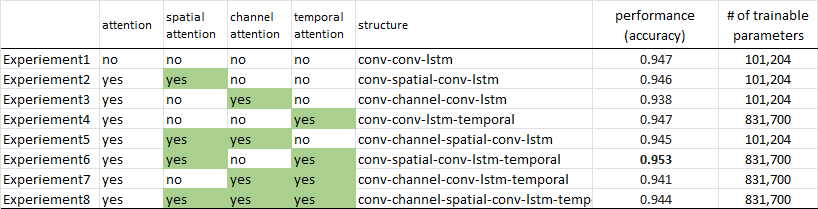

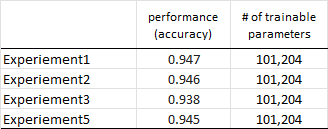

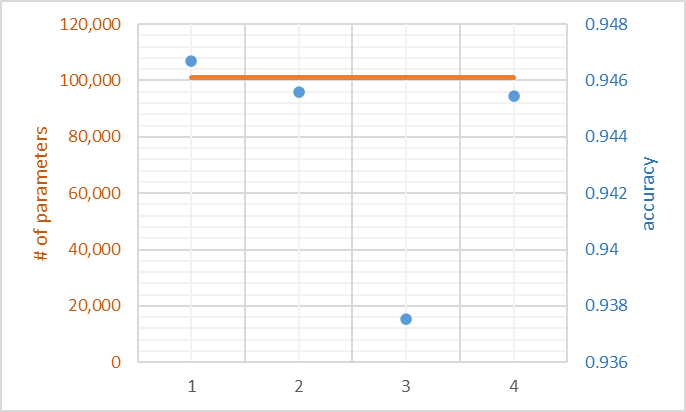